In [1]:
source("helper.R")

max_expid<-get_max("Log")+1
exp_name<-"PricingT"
log_dir<-glue("Log/{max_expid}.{exp_name}")
logger=get_logger(log_dir, log_name = "log", debug = TRUE)
futile.logger::flog.info("start experiment", name = "log")

## get logger

use_saudi<-FALSE
seed_random<-123
n=30

futile.logger::flog.info(glue("use_saudi: {use_saudi}"), name = "log")

set.seed(seed_random)

futile.logger::flog.info(glue("use seed: {seed_random}"), name = "log")

futile.logger::flog.info(glue("number of experiments: {n}"), name = "log")

if(!use_saudi){

    data_ori <- as.data.frame(read_csv("data/IFclose.csv"))
    logpt<-log(data_ori$close)
    logreturn <-logpt[2:length(logpt)]-logpt[1:(length(logpt)-1)]
    date <- as.Date(as.character(data_ori$Date[1:(length(data_ori$Date)-1)]), format = "%Y%m%d")
    date_timeindex_ori<-as.numeric(as.POSIXct(date)) 
    date_timeindex <- (date_timeindex_ori - min(date_timeindex_ori))/86400 ## 1 day = 86400 seconds
    data = data.frame(logreturn = logreturn, times = date_timeindex)
    data <- rbind(data, data.frame(logreturn = NA, times = max(date_timeindex):(max(date_timeindex)+31)))
    mesh <- fm_mesh_1d(data$times)
}else{
    data_ori <- as.data.frame(read_csv("data/1180_vol.csv"))
    logpt<-log(data_ori$Close)
    logreturn <-logpt[2:length(logpt)]-logpt[1:(length(logpt)-1)] ## 1 day = 86400 seconds
    date <- data_ori$Date[1:(length(data_ori$Date)-1)]
    date_timeindex_ori<-as.numeric(as.POSIXct(date)) 
    date_timeindex <- (date_timeindex_ori - min(date_timeindex_ori))/86400
    data = data.frame(logreturn = logreturn, times = date_timeindex)
    data <- rbind(data, data.frame(logreturn = NA, times = max(date_timeindex):(max(date_timeindex)+31)))
    mesh <- fm_mesh_1d(data$times)
}



Warning message:
“package ‘INLA’ was built under R version 4.5.0”
Loading required package: Matrix



This is INLA_25.06.07 built 2025-06-11 18:54:45 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


This is rSPDE 2.5.1
- See https://davidbolin.github.io/rSPDE for vignettes and manuals.



INFO [2025-09-10 10:53:12] start experiment
INFO [2025-09-10 10:53:12] use_saudi: FALSE
INFO [2025-09-10 10:53:12] use seed: 123
INFO [2025-09-10 10:53:12] number of experiments: 30


Rows: 1595 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ins_id
dbl (2): Date, close

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [2]:
set.seed(123)

## best fit stochvol IF,2/137.3123/0.5628
## best fit stochvol SR,4/118.271/0.7802
best.rspde.order<-2
best.prior.range.nominal<-137.3123
best.prior.std.dev.nominal<-0.5628









## best fit IF,2/137.3123/0.5628

In [3]:

OU_model <- rspde.matern(
    mesh = mesh,
    parameterization = "matern",
    rspde.order = best.rspde.order,
    prior.range.nominal = best.prior.range.nominal,
    prior.std.dev.nominal = best.prior.std.dev.nominal
  )
    
    formula_OU <- logreturn ~ -1 + Intercept(1)+ field(times, model = OU_model)
fit<-bru(formula_OU, family="stochvol.t", data = data)
result_fit<- rspde.result(fit, "field", OU_model, parameterization="matern")
summary(result_fit)

Warning message in rspde.result(fit, "field", OU_model, parameterization = "matern"):
“the mean or mode of nu is very close to nu.upper.bound, please consider increasing nu.upper.bound, and refitting the model.”


,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
std.dev,0.623031,0.0881128,0.466713,0.61739,0.812164,0.606918
range,94.906000,25.1170000,54.507200,91.93670,152.553000,86.313200
nu,1.459660,0.4009320,0.555599,1.54350,1.970750,1.935350


In [4]:
library(lubridate)
# 假设 date 是一个 Date 向量
#date <- as.Date(c("2025-07-10", "2025-07-15", "2025-07-20"))  # 示例数据

# 获取最后一天
last_day <- max(date)
# 生成从 next_day 开始到下个月同一天之前的所有日期
next_day <- last_day + 1
end_day <- as.Date("2024-05-17")

# 生成完整序列
all_days <- seq.Date(from = next_day, to = end_day, by = "day")

# 只保留非周末（即工作日）
biz_days <- all_days[!weekdays(all_days) %in% c("Saturday", "Sunday")]
date_timeindex_new<-as.numeric(as.POSIXct(biz_days)) 
date_timeindex_new <- (date_timeindex_new - min(date_timeindex_ori))/86400 ## 1 day = 86400 seconds
# 保存到数据框
new_data <- data.frame(times = date_timeindex_new)



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [5]:
discount_factor<- 1.02**(-21/252)

In [8]:
delta_S_T<-generate(fit, new_data, ~ exp((field+Intercept)/2), n.samples = 100000)

In [9]:

dof <- fit$summary.hyperpar$mean[1]

# t分布缩放因子 (保持期望标准差 = delta_S_T)
scale <- as.vector(delta_S_T) / sqrt(dof / (dof - 2))

# 生成随机矩阵
random_return_rate <- matrix(
  rt(length(delta_S_T), df = dof) * scale,
  nrow = nrow(delta_S_T),
  ncol = ncol(delta_S_T)
)

In [10]:
return_rate_to_end<-exp(colSums(random_return_rate))
simulated_final_prices <- data_ori$close[length(data_ori$close)] * return_rate_to_end

In [11]:
data_ori$close[length(data_ori$close)]

[1] 3540.547

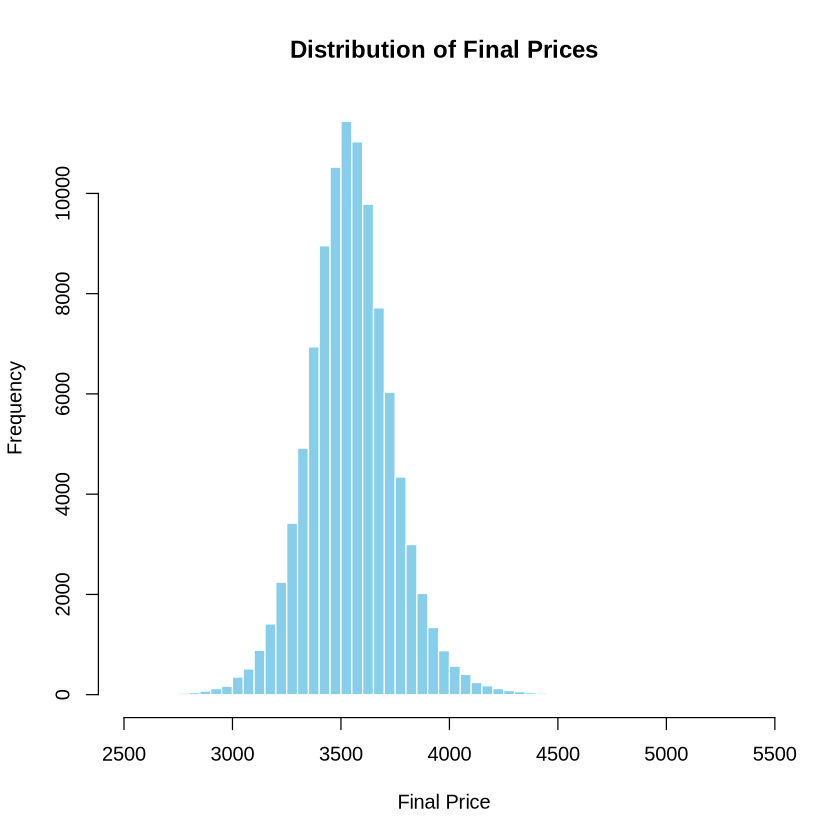

In [12]:
par(bg = "white")
hist(simulated_final_prices, 
     breaks = 50, col = "skyblue", border = "white",
     main = "Distribution of Final Prices", xlab = "Final Price")

In [13]:
expected_payoff <- function(sim_prices, K, type = c("call", "put"), discount_factor = 1) {
  # sim_prices: simulated prices
  # K: strike price
  # type: "call" or "put"
  # discount_factor: discount factor, default=1 (if you need e^{-rT} outside)
  
  type <- match.arg(type)
  
  if (type == "call") {
    payoff <- pmax(sim_prices - K, 0)
  } else {
    payoff <- pmax(K - sim_prices, 0)
  }
  
  return(mean(payoff) * discount_factor)
}

In [14]:
pricing_values<-list()



call_records<-as.data.frame(read_csv("data/calls_records.csv"))
put_records<-as.data.frame(read_csv("data/put_records.csv"))



for (i in 1:nrow(call_records)){
    strike<-call_records$strike[i]
    call_price<-expected_payoff(simulated_final_prices, K = strike, type = "call", discount_factor = discount_factor)
    pricing_values$call_records[i]<-call_price
}

for (i in 1:nrow(put_records)){
    strike<-put_records$strike[i]
    put_price<-expected_payoff(simulated_final_prices, K = strike, type = "put", discount_factor = discount_factor)
    pricing_values$put_records[i]<-put_price
}


call_records$theoretical_price<-pricing_values$call_records
put_records$theoretical_price<-pricing_values$put_records



write.csv(call_records, glue("{log_dir}/calls_records_with_theoretical_price.csv"))
write.csv(put_records, glue("{log_dir}/put_records_with_theoretical_price.csv"))






Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
find_market_col <- function(df) {
  cand <- c("market_price", "price", "close", "mid")
  hit <- cand[cand %in% names(df)]
  if (length(hit) == 0) stop("未找到市场价格列，请在 cand 中加入正确列名。已有列：", paste(names(df), collapse=", "))
  hit[1]
}
plot_prices <- function(df, title = "Calls", xlab = "Strike", ylab = "Price", underlying = NULL) {
  # 选择市场价格列
  mcol <- find_market_col(df)

  # 仅保留需要列并去 NA
  keep <- c("strike", mcol, "theoretical_price")
  df2 <- df[keep]
  df2 <- df2[complete.cases(df2), ]

  # 按 strike 排序
  ord <- order(df2$strike)
  x  <- df2$strike[ord]
  yM <- df2[[mcol]][ord]              # 市场价格
  yT <- df2$theoretical_price[ord]    # 理论价格

  # 确定坐标范围
  yr <- range(c(yM, yT), finite = TRUE)

  # 画图（白底）
  par(bg = "white")
  plot(x, yM, type = "l", lwd = 2,
       col = rgb(0,0,1,0.6),             # 半透明蓝色
       xlab = xlab, ylab = ylab,
       main = title, ylim = yr, cex.axis=1.2, cex.lab=1.2, cex.main=1.3)
  lines(x, yT, lwd = 2, lty = 2,
        col = rgb(1,0,0,0.6))            # 半透明红色

  # 如果提供了 underlying，就画一条竖线
  if (!is.null(underlying)) {
    abline(v = underlying, col = "black", lty = 3, lwd = 2)
  }

  legend("topleft",
         legend = c("Market", "Theoretical", if (!is.null(underlying)) "Underlying" else NULL),
         lwd = c(2, 2, if (!is.null(underlying)) 2 else NULL),
         lty = c(1, 2, if (!is.null(underlying)) 3 else NULL),
         col = c(rgb(0,0,1,0.6), rgb(1,0,0,0.6), if (!is.null(underlying)) "black" else NULL),
         bty = "n")
}


# --- 分两幅图显示：左边 Call，右边 Put ---
png(glue( "{log_dir}/calls_puts.png"), width=2000, height=1000, res=200)  # 像素宽高
op <- par(mfrow = c(1, 2), mar = c(4, 4, 3, 1), cex=1.2)
plot_prices(call_records, title = "Call: Market vs Theoretical", xlab = "Strike", ylab = "Price",underlying=data_ori$close[length(data_ori$close)])
plot_prices(put_records,  title = "Put: Market vs Theoretical",  xlab = "Strike", ylab = "Price",underlying=data_ori$close[length(data_ori$close)])
par(op)
dev.off()

agg_record_103217711 
                   2